In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten ,Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation ,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG ,Image
import tensorflow as tf
print("tensorflow version: ",tf.__version__)



tensorflow version:  2.13.0


EXPLORING DATASET

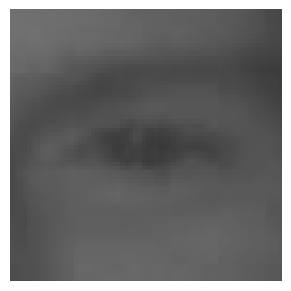

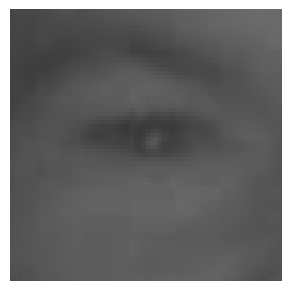

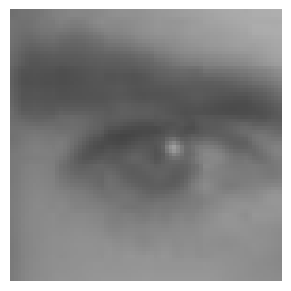

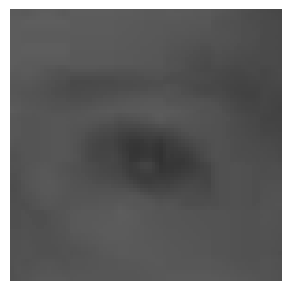

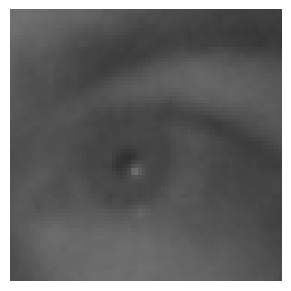

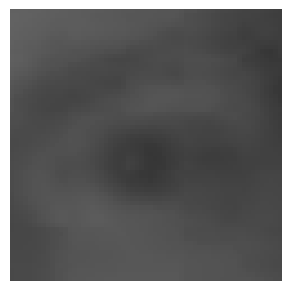

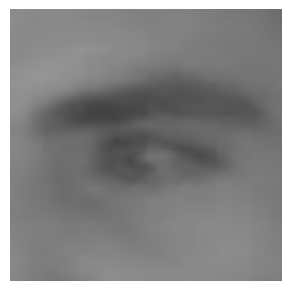

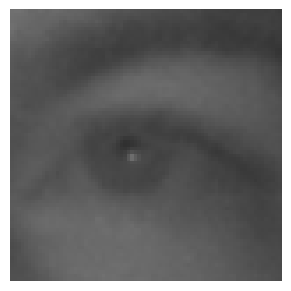

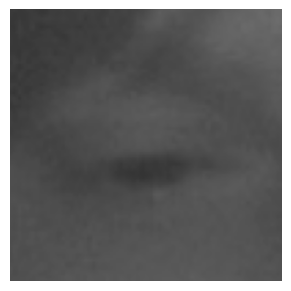

In [2]:
images= glob("C:/Users/Neha/Desktop/drowsiness/train_eye/open_eye/**")
for i in range(9):
    image= random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image)); plt.axis('off')
    

PREPARING DATA FOR TRAINING

In [3]:
img_size = 48
batch_size = 32

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(
    "C:/Users/Neha/Desktop/drowsiness/train_eye/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(
    "C:/Users/Neha/Desktop/drowsiness/test_eye/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)


Found 48000 images belonging to 2 classes.
Found 48000 images belonging to 2 classes.


DEFINING MODEL

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

def DenseLayer(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

def create_eye_state_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Convolution(input_layer, 64, (3, 3))
    x = Convolution(x, 128, (5, 5))
    x = Convolution(x, 512, (3, 3))
    x = Convolution(x, 512, (3, 3))

    x = Flatten()(x)
    x = DenseLayer(x, 256)
    x = DenseLayer(x, 512)
    output_layer = Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' for binary classification

    model = Model(inputs=input_layer, outputs=output_layer)
    
    opt = Adam(lr=0.0005)
    model.compile(loss='binary_crossentropy',  # Use binary crossentropy for binary classification
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

model = create_eye_state_model((48, 48, 1))
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

INITIALISING MODEL

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Assuming you have a train_generator and validation_generator for eye state data
epochs = 15
steps_per_epoch = len(train_generator) // batch_size
validation_steps = len(validation_generator) // batch_size
#steps_per_epoch = train_generator.n // train_generator.batch_size
#validation_steps = validation_generator.n // validation_generator.batch_size

# Checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("eye_state_model_weights.h5", 
                             monitor='val_accuracy', 
                             save_weights_only=True, 
                             mode='max', 
                             verbose=1)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=2, 
                              min_lr=0.00001)

callbacks = [checkpoint, reduce_lr]



history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15
46/46 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7548
Epoch 1: saving model to eye_state_model_weights.h5
46/46 [==============================] - 96s 2s/step - loss: 0.5185 - accuracy: 0.7548 - val_loss: 18.0793 - val_accuracy: 0.5177 - lr: 0.0010
Epoch 2/15
46/46 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8906
Epoch 2: saving model to eye_state_model_weights.h5
46/46 [==============================] - 94s 2s/step - loss: 0.2982 - accuracy: 0.8906 - val_loss: 1.0800 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 3/15
46/46 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9151
Epoch 3: saving model to eye_state_model_weights.h5
46/46 [==============================] - 91s 2s/step - loss: 0.2016 - accuracy: 0.9151 - val_loss: 0.6904 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 4/15
46/46 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.9226
Epoch 4: saving model to eye_state_model_

In [6]:
model.evaluate(validation_generator)

1500/1500 [==============================] - 735s 490ms/step - loss: 0.1223 - accuracy: 0.9524


[0.12231215089559555, 0.9523749947547913]

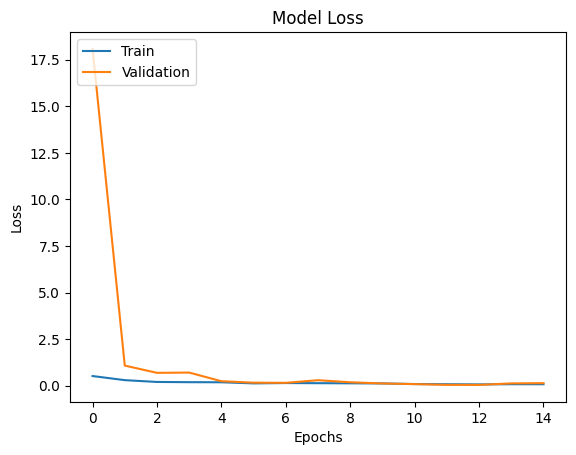

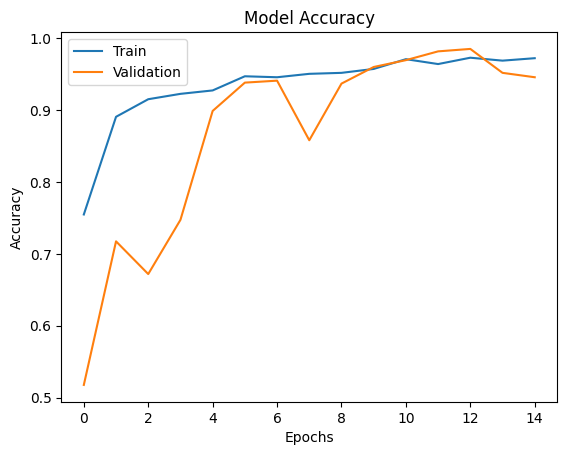

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [8]:
# Save model architecture to JSON file
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model.save_weights("model_a_weights.h5")
